In [ ]:
### Prerna Singh (edited by John D'Uva)
# Original: https://github.com/prernasingh11/CLARITY/blob/master/Cell_extractor4_22.ipynb

# Isolate cell regions and non-cell regions (using centers of mass) for 3D sliced Clarity images
# Use a brain-wide illumination correction for intensity
# Extract 10x the non-cell data than cell data by selecting points within 20 pixels x y and z of cells

In [1]:
import numpy as np
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import random
import csv
import pandas as pd
import cv2

from cloudvolume import CloudVolume, view
from tifffile import imsave
from brainlit.utils.session import NeuroglancerSession
import pickle as pkl
import time
import deflate

begin = 6000
end = 6250

/Users/johnduva/opt/anaconda3/envs/neuroData3_7/lib/python3.7/site-packages/python_jsonschema_objects/__init__.py:53: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  self.schema["$schema"]


In [ ]:
# download a whole image stack into a numpy array from the cloud
vol = CloudVolume('https://dlab-colm.neurodata.io/brian-dev/'+date+'_ENTANGLaGFP-'+section+'/Ch1_470_bias_corrected/')
image = vol[:,:,:]

# save each of 'i' z-planes locally (from the tiff stack)
for i in range(0,image.shape[2]):
    if i <10:
        name = "brian-dev_"+date+"_ENTAGLaGP-"+section+"_Ch0_470_z0-2160_y0-2560_z000%i" %i
    elif i <100:
        name = "brian-dev_"+date+"_ENTAGLaGP-"+section+"_Ch0_470_z0-2160_y0-2560_z00%i" %i
    elif i <1000:
        name = "brian-dev_"+date+"_ENTAGLaGP-"+section+"_Ch0_470_z0-2160_y0-2560_z0%i" %i
    else:
        name = "brian-dev_"+date+"_ENTAGLaGP-"+section+"_Ch0_470_z0-2160_y0-2560_z%i" %i
    imsave(section+"/%s.tiff" %name, image[:,:,i])

In [ ]:
# Two options for pulling data from s3 using CloudVolume (both work)...

# Option 1) FAST, MEMORY INTENSIVE: 
# Download them 52 slices at a time and then write out the files by cutting them out of memory.

# Option 2) MEDIUM, DISK INTENSIVE: 
# Loop through one at a time but cache the last Z chunks on disk

In [ ]:
# OPTION 2
dir = "s3://open-neurodata/brainlit/brain1"
vol = CloudVolume(dir, parallel=True, fill_missing=True, cache=True, mip=1)

for z in range(begin, end):
    if z % vol.chunk_size.z == 0:
        vol.cache.flush()
    image = vol[:, :, z]
    pkl.dump(image, open("../../../../pickles5/image"+str(z)+".pkl", "wb"))

Downloading: 2036it [00:19, 103.93it/s][00:20<01:02, 10.41it/s] 
Downloading: 2030it [00:20, 99.34it/s]                          
Downloading: 2026it [00:20, 99.09it/s]
Downloading: 2032it [00:20, 99.07it/s] [00:20<00:52, 14.13it/s]]
Downloading: 2044it [00:20, 99.66it/s] [00:20<00:29, 20.18it/s] 
Downloading: 2038it [00:20, 99.37it/s]
Downloading: 2028it [00:20, 98.52it/s]
Downloading: 2042it [00:21, 97.22it/s]                          
Downloading: 2036it [00:32, 62.47it/s]                          
Downloading: 2040it [00:48, 41.64it/s]                          
Downloading: 2040it [00:52, 39.17it/s]                          
Downloading: 2042it [00:56, 36.03it/s]                          
Downloading: 2042it [00:56, 35.85it/s]                          
Downloading: 2044it [00:57, 35.59it/s]                          
Downloading: 2028it [00:58, 34.42it/s]                          
Downloading: 2040it [00:59, 34.15it/s]                          
Downloading: 1448it [00:01, 891.15it/s

Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 1722it [00:01, 1680.91it/s]00:03<00:03, 176.49it/s] 
Downloading: 1924it [00:00, 2944.15it/s]
Downloading: 1952it [00:01, 1745.78it/s]                         
Downloading: 2026it [00:01, 1062.58it/s]                        ]
Downloading: 2006it [00:01, 1188.68it/s]                         
Downloading: 2002it [00:02, 692.19it/s]                         
Downloading: 2014it [00:05, 355.79it/s]                          
Downloading: 2034it [00:04, 451.10it/s]                          
Downloading: 2042it [00:04, 474.84it/s]                          
Downloading: 2038it [00:04, 467.97it/s]                          
Downloading: 2018it [00:04, 425.42it/s]                         
Downloading: 2040it [00:04, 419.40it/s]                          
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 2016it [00:03, 635.68it/s]                          
Downloading: 2036it [00:01, 1715.54it/s]                     

Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 2008it [00:01, 1798.88it/s]                          
Downloading: 1944it [00:01, 1597.57it/s]                        
Downloading: 2028it [00:04, 501.72it/s]                         
Downloading: 2046it [00:02, 983.90it/s]                         
Downloading: 2036it [00:03, 622.60it/s]                          
Downloading: 1998it [00:03, 611.45it/s]
Downloading: 2028it [00:04, 494.28it/s]                         
Downloading: 2028it [00:04, 449.56it/s]                          
Downloading: 2000it [00:04, 433.79it/s]                         
Downloading: 2024it [00:04, 424.38it/s]                         ]
Downloading: 2032it [00:04, 407.12it/s]                          
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 2038it [00:00, 4247.96it/s]                           
Downloading: 1994it [00:01, 1437.77it/s]                         
Downloading: 1992it [00:01, 1716.36it/s]00:01<00:01, 330.02it/

Downloading: 1952it [00:01, 1811.72it/s]                         
Downloading: 2024it [00:01, 1222.85it/s]                         
Downloading: 2028it [00:02, 769.24it/s][00:02<00:01, 208.06it/s] 
Downloading: 2038it [00:02, 693.13it/s]                         
Downloading: 2042it [00:03, 553.14it/s][00:03<00:00, 161.37it/s] 
Downloading: 2046it [00:04, 471.25it/s]                          
Downloading: 2032it [00:04, 473.89it/s]                          
Downloading: 2038it [00:04, 473.58it/s]                          
Downloading: 2028it [00:04, 467.22it/s]                          
Downloading: 2006it [00:04, 446.17it/s]                         
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 1372it [00:02, 468.51it/s][00:00<00:01, 418.39it/s] 
Downloading: 1860it [00:01, 1534.21it/s]                         
Downloading: 2012it [00:00, 2697.05it/s]                         
Downloading: 1992it [00:02, 877.30it/s]                         ]
Downloading: 2046it [00:

Downloading: 2042it [00:48, 42.31it/s]                          
Downloading: 2040it [00:56, 35.82it/s]                          
Downloading: 2042it [00:57, 35.34it/s]                          
Downloading: 2046it [00:59, 34.13it/s]                          
Downloading: 2044it [01:00, 33.66it/s]                          
Downloading: 2046it [01:00, 33.60it/s]                          
Downloading: 2038it [01:01, 33.25it/s]                          
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 1864it [00:00, 3187.40it/s]
Downloading: 2004it [00:00, 18022.73it/s]            448.17it/s] 
Downloading: 1682it [00:00, 2806.63it/s]                         
Downloading: 1958it [00:00, 3343.60it/s]                         
Downloading: 2024it [00:03, 618.25it/s]                          
Downloading: 2046it [00:03, 601.79it/s]                          
Downloading: 2016it [00:03, 604.31it/s]                          
Downloading: 2040it [00:06, 335.50it/s]               

Downloading: 1992it [00:04, 456.88it/s]                         
Downloading: 2040it [00:04, 473.52it/s]                          
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]2253.86it/s]
Downloading: 1722it [00:00, 4213.23it/s]                         
Downloading: 1784it [00:00, 4547.99it/s]
Downloading: 1946it [00:00, 5440.66it/s]                         
Downloading: 1736it [00:00, 4379.88it/s]                         
Downloading: 2020it [00:01, 1858.87it/s]00:03<00:02, 229.74it/s] 
Downloading: 2016it [00:03, 666.71it/s]                          
Downloading: 2022it [00:05, 379.33it/s]                          
Downloading: 1998it [00:04, 467.30it/s]                         
Downloading: 2008it [00:04, 463.16it/s]                         ]
Downloading: 2026it [00:04, 488.85it/s]                          
Downloading: 2006it [00:04, 454.33it/s]                         
Downloading: 2018it [00:04, 474.53it/s]                          
Downloading:  60%|█████▉    | 614/1024

Downloading: 1892it [00:00, 3748.52it/s]
Downloading: 1886it [00:00, 4953.79it/s]
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 1984it [00:00, 2085.99it/s]                         
Downloading: 2010it [00:02, 719.78it/s]                          
Downloading: 1980it [00:03, 509.02it/s]                         
Downloading: 2020it [00:03, 534.19it/s]                         
Downloading: 2012it [00:06, 316.36it/s]                         
Downloading: 2014it [00:04, 443.68it/s]                         
Downloading: 2012it [00:04, 495.44it/s]                         ]
Downloading: 2044it [00:04, 505.16it/s]                          
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]1089.32it/s]
Downloading: 1930it [00:00, 5133.98it/s]                         
Downloading: 1992it [00:01, 1081.96it/s]                         
Downloading: 2046it [00:03, 636.79it/s]                         
Downloading: 2010it [00:03, 622.69it/s]                         
Downloading:

Downloading: 2036it [00:02, 681.40it/s]                         
Downloading: 1984it [00:04, 476.60it/s]                         
Downloading: 2016it [00:04, 452.33it/s]                          
Downloading: 2028it [00:04, 455.46it/s]                         
Downloading: 2020it [00:04, 442.81it/s]                          
Downloading: 2036it [00:04, 449.23it/s]                          
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]2805.83it/s]
Downloading: 1080it [00:02, 392.28it/s]
Downloading: 1166it [00:02, 432.05it/s]
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]537.48it/s]
Downloading: 1988it [00:03, 634.09it/s]                          
Downloading: 2016it [00:03, 576.87it/s]                         
Downloading: 1996it [00:05, 385.61it/s][00:02<00:01, 175.73it/s]
Downloading: 2028it [00:03, 522.43it/s]                          
Downloading: 2026it [00:04, 477.61it/s]                          
Downloading: 2040it [00:04, 491.10it/s]                          
Do

Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 1600it [00:02, 637.93it/s]                         ]
Downloading: 1218it [00:00, 1407.57it/s]                         
Downloading: 2010it [00:00, 2281.53it/s]00:00<00:00, 544.41it/s] 
Downloading: 2022it [00:01, 1277.49it/s]                         
Downloading: 2016it [00:03, 598.25it/s]                          
Downloading: 2046it [00:03, 551.81it/s]                          
Downloading: 2024it [00:04, 464.96it/s]                         
Downloading: 2006it [00:04, 442.94it/s]                         
Downloading: 2044it [00:04, 440.94it/s]                          
Downloading: 2034it [00:04, 425.59it/s]                          
Downloading: 2040it [00:04, 431.50it/s]                          
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 1172it [00:02, 556.71it/s]
Downloading: 1376it [00:02, 509.81it/s]
Downloading: 1966it [00:00, 5961.57it/s]
Downloading: 2034it [00:00, 4886.44it/s]       

Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 1982it [00:00, 14694.85it/s]0:00<00:00, 3064.76it/s]
Downloading: 2028it [00:01, 1979.37it/s]                         
Downloading: 2006it [00:02, 676.37it/s]                         ]
Downloading: 2026it [00:04, 491.21it/s]                          
Downloading: 2008it [00:03, 510.98it/s][00:03<00:00, 191.66it/s] 
Downloading: 2018it [00:04, 471.56it/s]                          
Downloading: 2022it [00:04, 480.27it/s]                         ]
Downloading: 2006it [00:04, 450.74it/s]                          
Downloading: 2016it [00:06, 302.23it/s]                         
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]            
Downloading: 1918it [00:00, 3143.27it/s]00:00<00:01, 436.88it/s] 
Downloading: 1648it [00:00, 1859.49it/s]
Downloading: 1934it [00:00, 2710.12it/s]
Downloading: 1714it [00:00, 2697.71it/s]
Downloading: 2014it [00:01, 1094.76it/s]                         
Downloading: 2038it [00:03, 594.

Downloading: 2024it [00:03, 517.97it/s]                         
Downloading: 2046it [00:04, 478.85it/s]                          
Downloading: 2006it [00:05, 378.85it/s]                          
Downloading: 2006it [00:06, 323.52it/s]                         
Downloading: 2036it [00:04, 422.62it/s]                          
Downloading: 2012it [00:05, 367.26it/s]                         
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 1738it [00:02, 813.03it/s]                         
Downloading: 2036it [00:01, 1290.88it/s]                         
Downloading: 2000it [00:03, 653.57it/s]                          
Downloading: 2008it [00:03, 578.51it/s]                          
Downloading: 2028it [00:03, 538.00it/s]                          
Downloading: 2028it [00:04, 476.86it/s][00:04<00:00, 211.32it/s]]
Downloading: 2008it [00:04, 465.70it/s]                          
Downloading: 2002it [00:04, 443.16it/s]                         ]
Downloading: 2028it [00:04

Downloading: 2034it [00:06, 301.46it/s]                          
Downloading: 1984it [00:04, 453.79it/s]                         
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]171.18it/s]]
Downloading: 1956it [00:02, 954.03it/s]                          
Downloading: 2016it [00:03, 607.16it/s]                          
Downloading: 2046it [00:03, 583.48it/s][00:03<00:00, 162.00it/s] 
Downloading: 2022it [00:03, 510.80it/s]                          
Downloading: 2012it [00:04, 450.96it/s]                          
Downloading: 2042it [00:04, 431.02it/s]                          
Downloading: 2018it [00:04, 426.97it/s]                         
Downloading: 2022it [00:06, 292.29it/s]                          
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 1960it [00:00, 4168.81it/s] 
Downloading: 1932it [00:02, 770.01it/s]                         
Downloading: 2036it [00:00, 4633.87it/s]                         
Downloading: 2016it [00:01, 1298.17it/s]         

Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 2046it [00:00, 5704.43it/s]00:00<00:00, 1789.62it/s]  
Downloading: 2004it [00:00, 9568.33it/s]                          
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]147.63it/s]
Downloading: 2034it [00:01, 1081.32it/s]                         
Downloading: 2004it [00:04, 483.08it/s]                          
Downloading: 2042it [00:03, 558.83it/s]                          
Downloading: 2016it [00:06, 296.97it/s]                         ]
Downloading: 2016it [00:04, 455.09it/s]                          
Downloading: 2042it [00:04, 451.12it/s]                          
Downloading: 2008it [00:04, 436.91it/s]                         
Downloading: 2028it [00:04, 436.97it/s]                         
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]4185.22it/s]
Downloading: 2046it [00:00, 7100.94it/s]00:02<00:04, 174.90it/s]   
Downloading: 2034it [00:01, 1240.17it/s]                         
Downloading: 2016it 

Downloading: 2042it [00:01, 1219.77it/s]                         
Downloading: 2034it [00:03, 637.41it/s]                         
Downloading: 2046it [00:05, 353.35it/s]                          
Downloading: 2034it [00:04, 493.17it/s]                          
Downloading: 2034it [00:04, 495.76it/s]                          
Downloading: 2036it [00:04, 475.57it/s] [00:04<00:00, 220.18it/s]
Downloading: 2046it [00:04, 463.01it/s]                          
Downloading: 2044it [00:04, 466.69it/s]                          
Downloading:   0%|          | 0/1024 [00:00<?, ?it/s]
Downloading: 1888it [00:02, 750.18it/s]
Downloading: 2034it [00:00, 3996.57it/s]                           
Downloading: 1776it [00:00, 3586.72it/s]                         
Downloading: 1994it [00:00, 3282.40it/s]                         
Downloading: 2036it [00:01, 1335.88it/s]                         
Downloading: 2024it [00:03, 669.10it/s]                         
Downloading: 2018it [00:03, 540.30it/s]         

In [ ]:
# OPTION 1
dir = "s3://open-neurodata/brainlit/brain1"
vol = CloudVolume(dir, parallel=True, fill_missing=True)
        
chunk = 13
begin = 6000
end = 6300
for z in range(begin, end, chunk):
    image = vol[:, :, z:(z+chunk)]
    for j in range(chunk):
        image_slice = image[:,:,j]
        pkl.dump(image_slice, open("../../../../pickles4/image"+str(z+j)+".pkl", "wb"))

Downloading: 8182it [01:38, 83.27it/s]                           
Downloading: 8190it [05:31, 24.71it/s]                           
Downloading: 8186it [09:49, 13.88it/s]                            
Downloading: 8190it [13:04, 10.44it/s]                          
Downloading: 8184it [13:37, 10.01it/s]                          
Downloading: 8186it [15:30,  8.79it/s]                          
Downloading: 8188it [16:43,  8.16it/s]                          
Downloading: 8184it [17:35,  7.76it/s]                          
Downloading: 8186it [17:50,  7.65it/s]                          
Downloading: 8190it [17:52,  7.63it/s]                          
Downloading: 8190it [18:10,  7.51it/s]                          
Downloading: 8190it [18:26,  7.40it/s]                          
Downloading: 8188it [18:26,  7.40it/s]                          
Downloading: 8190it [18:29,  7.38it/s]                          
Downloading: 8188it [18:30,  7.38it/s]                          
Downloading: 8180it [

Downloading: 16380it [36:06,  7.56it/s]                         
Downloading: 16376it [36:06,  7.56it/s]                         
Downloading: 16376it [36:06,  7.56it/s]                         
Downloading: 8172it [02:30, 54.22it/s]                           
Downloading: 8176it [04:00, 34.00it/s]                            
Downloading: 8186it [09:56, 13.72it/s]                            
Downloading: 8190it [11:55, 11.45it/s]                          
Downloading: 8188it [13:47,  9.89it/s]                          
Downloading: 8186it [15:26,  8.84it/s]                          
Downloading: 8188it [16:59,  8.03it/s]                          
Downloading: 8182it [17:45,  7.68it/s]                          
Downloading: 8190it [17:58,  7.59it/s]                          
Downloading: 8190it [18:06,  7.54it/s]                          
Downloading: 8188it [18:31,  7.37it/s]                          
Downloading: 8190it [18:34,  7.35it/s]                          
Downloading: 8190it 

Downloading: 16376it [35:46,  7.63it/s]                         
Downloading: 16382it [35:50,  7.62it/s]                         
Downloading: 16380it [35:51,  7.61it/s]                         
Downloading: 16382it [35:53,  7.61it/s]                         
Downloading: 16378it [35:55,  7.60it/s] [35:55<00:01, 29.50it/s]
Downloading: 16382it [35:56,  7.60it/s]                         
Downloading: 8186it [01:04, 127.58it/s]                          
Downloading: 8188it [02:51, 47.84it/s]                           
Downloading: 8184it [09:22, 14.55it/s]                           
Downloading: 8184it [10:05, 13.51it/s]6 [10:05<09:45,  3.40it/s]
Downloading: 8190it [13:33, 10.07it/s]                          
Downloading: 8190it [15:02,  9.08it/s]                          
Downloading: 8190it [16:04,  8.49it/s]                          
Downloading: 8190it [16:53,  8.08it/s]                          
Downloading: 8184it [17:06,  7.97it/s]                          
Downloading: 8188it [1

In [ ]:
# Create empty np array to load pkl files into (33792 x 25600 x 294)
arr = np.empty([16896, 12800, 1])
# arr = np.empty([33792, 25600, 1])
               
# 6000+len(os.listdir('../../../../pickles4'))-1 
    
# load pickle data
for i in range(6000, 6290):
    with open("../../../../pickles5/image"+str(i)+".pkl", 'rb') as data1:
        data2 = pkl.load(data1)
        data3 = np.squeeze(data2,3)
        arr = np.dstack((arr, data3))
        #print(i)

# Remove the first slice (empty)
arr = arr[:,:,1:-1]

6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021


In [5]:
# file_path_img = os.path.join('12L_bias_corrected')
# list = os.listdir(file_path_img)
# print(list)
os.listdir('12L')

['brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z0003.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z0453.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z0900.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z1242.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z0845.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z1307.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z0146.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z0516.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z1184.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z0795.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z0280.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z1215.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z0957.tiff',
 'brian-dev_180704_ENTAGLaGP-12L_Ch0_470_z0-2160_y0-2560_z0404.tiff',
 'brian-dev_180704_E

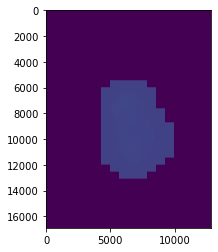

In [11]:
import matplotlib.pyplot as plt
test = arr[:,:,2]
plt.imshow(test)

In [101]:
# save each of 'i' z-planes locally (from the tiff stack)
for i in range(0, arr.shape[2] ):
    ii = i + begin
    if ii <10:
        name = "z000"+ str(begin+i)
    elif ii <100:
        name = "z00"+ str(begin+i)
    elif ii <1000:
        name = "z0"+ str(begin+i)
    else:
        name = "z" + str(begin+i)
    imsave("../../../../pickle_tiffs/%s.tiff" %name, arr[:,:,i])

In [123]:
# create directory
file_path_img = os.path.join('../../../../pickle_tiffs/')
# file_path_img = os.path.join('12L')
list = os.listdir(file_path_img)
print(list)
for file in list:
    print(file)

['z6000.tiff', 'z6001.tiff', 'z6002.tiff', 'z6003.tiff']
z6000.tiff
z6001.tiff
z6002.tiff
z6003.tiff


In [124]:
#preprocess the csv with file labels
fileLabelCSV = pd.read_csv('cellCenters.csv')
# fileLabelCSV = pd.read_csv('ENTANGLtrainingdata/E12L-training.csv')

#make ordered lists of each coordinate dimension
xfileLabelCSV=(fileLabelCSV['Center of Mass (Geometry): X (px)']).to_list()
yfileLabelCSV=(fileLabelCSV['Center of Mass (Geometry): Y (px)']).to_list()
zfileLabelCSV=(fileLabelCSV['Center of Mass (Geometry): Z (px)']).to_list()
      
ROI = np.zeros((len(xfileLabelCSV),12,12,12))

In [ ]:
# str(i) 
# str(file)

In [135]:
#create a list of ranges +-6 from the cell coordinate that are invalid when accumulating non-cell regions
x_invalid=[]
y_invalid=[]
z_invalid=[]

# for index0 in range(0, len(xfileLabelCSV)):
index0 = 0
voxel = np.zeros((12,12,12))

#current coordinates
xcoord = int(xfileLabelCSV[index0])
ycoord = int(yfileLabelCSV[index0])
zcoord = int(zfileLabelCSV[index0])


#for the ncrs
x_invalid+=[*range(int(xfileLabelCSV[index0])-6,int(xfileLabelCSV[index0])+6)]
y_invalid+=[*range(int(yfileLabelCSV[index0])-6,int(yfileLabelCSV[index0])+6)]
z_invalid+=[*range(int(zfileLabelCSV[index0])-6,int(zfileLabelCSV[index0])+6)]


#for every z, append the x&ys
for index, i in enumerate(range(zcoord-6,zcoord+6)):
    for file in list:

        if str("tif") in str(file):
            if len(str(i))==1:
                i=str("000"+str(i))
            if len(str(i))==2:
                i=str("00"+str(i))
            if len(str(i))==3:
                i=str("0"+str(i))
            # if len(str(i))==4: don't need to pad it
            if str(i) in str(file):
                scan1 = np.asarray(Image.open(file_path_img + '/'+file))
                scan = np.zeros(scan1.shape)
                scan = cv2.normalize(scan1,scan, 0, 255, cv2.NORM_MINMAX)
                plane = scan[xcoord-6:xcoord+6,ycoord-6:ycoord+6]
                plt.imshow(plane)
                plt.show()
    voxel[index]=np.asarray(plane)
ROI[index0]=np.asarray(voxel)

print('Total number of CellRegions: ', len(zfileLabelCSV))


NameError: name 'plane' is not defined

In [ ]:
np.save('ROI'+section+'_bias_corrected.npy', ROI)

In [ ]:
#export cell coordinates as .npy
xcoordinate=(fileLabelCSV['Center of Mass (Geometry): X (px)']).to_numpy()
ycoordinate=(fileLabelCSV['Center of Mass (Geometry): Y (px)']).to_numpy()
zcoordinate=(fileLabelCSV['Center of Mass (Geometry): Z (px)']).to_numpy()

In [ ]:
#number of non-coding regions we want to isolate, lets say 515, same as number of cell regions
nNCMB = len(zfileLabelCSV)*10
NCR = []

#have 11 different coordinates for 1 non-cell region
for index0 in range(0,len(xfileLabelCSV)):
    #current coordinates
    xcoord = int(xfileLabelCSV[index0])
    ycoord = int(yfileLabelCSV[index0])
    zcoord = int(zfileLabelCSV[index0])
    ncrcell=[]
    while (len(ncrcell)) < 10:
        x_random = random.randint(7,20)
        y_random = random.randint(7,20)
        z_random = random.randint(7,20)
        #proceed =1
        #print("Random x,y,z for Non CMB Region:", x_random,y_random,z_random)

        #for i in x_invalid:
        #    if x_random == i:
        #        #print('x_false')
        #        proceed = 0
        #for i in y_invalid:
        #    if y_random == i:
        #        #print('y_false')
        #        proceed = 0
        #for i in z_invalid:
        #    if z_random == i:
        #        #print('z_false')
        #        proceed = 0
        if len(ncrcell) %8==0:
            #print("proceeding")
            ncrcell.append([xcoord+x_random,ycoord+y_random,zcoord+z_random])
        elif len(ncrcell) %8==1:
            #print("proceeding")
            ncrcell.append([xcoord-x_random,ycoord+y_random,zcoord+z_random])
        elif len(ncrcell) %8==2:
            #print("proceeding")
            ncrcell.append([xcoord+x_random,ycoord-y_random,zcoord+z_random])
        elif len(ncrcell) %8==3:
            #print("proceeding")
            ncrcell.append([xcoord+x_random,ycoord+y_random,zcoord-z_random])
        elif len(ncrcell) %8==4:
            #print("proceeding")
            ncrcell.append([xcoord+x_random,ycoord-y_random,zcoord-z_random])
        elif len(ncrcell) %8==5:
            #print("proceeding")
            ncrcell.append([xcoord-x_random,ycoord+y_random,zcoord-z_random])
        elif len(ncrcell) %8==6:
            #print("proceeding")
            ncrcell.append([xcoord-x_random,ycoord-y_random,zcoord+z_random])
        else:
            ncrcell.append([xcoord-x_random,ycoord-y_random,zcoord-z_random])
    for i in ncrcell:
        NCR.append(i)
    #print(len(NCR))
print("%s non-CMB regions were isolated." %(len(NCR)), "Adding to the master dictionary.")

In [11]:
for i in range(6000, 6293):
    print(i)

6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130
6131
6132
6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199


In [7]:
arr.shape

(16896, 12800, 6)

In [ ]:
NCR_total = np.zeros((len(NCR),12,12,12))

for index0 in range(0,len(NCR)):
    voxel = np.zeros((12,12,12))
    
    #current coordinates
    xcoord = int(NCR[index0][0])
    ycoord = int(NCR[index0][1])
    zcoord = int(NCR[index0][2])

    #for every z, append the x&ys
    for index,i in enumerate(range(zcoord-6,zcoord+6)):
        for file in list:
            if str("tif") in str(file):
                if len(str(i))==1:
                    i=str("000"+str(i))
                if len(str(i))==2:
                    i=str("00"+str(i))
                if len(str(i))==3:
                    i=str("0"+str(i))
                if str(i) in str(file).split("_")[7]:
                    scan1 = np.asarray(Image.open(file_path_img + '/'+file))
                    scan = np.zeros(scan1.shape)
                    scan = cv2.normalize(scan1,scan, 0, 255, cv2.NORM_MINMAX)
                    plane = scan[xcoord-6:xcoord+6,ycoord-6:ycoord+6]
        voxel[index] = np.asarray(plane)
    NCR_total[index0]=np.asarray(voxel)

In [ ]:
np.save('NCR'+section+'_bias_corrected.npy',np.asarray(NCR_total))

In [ ]:
NCR[2]

In [ ]:
image.shape[2]

In [ ]:
arr = np.empty([33792, 25600, 293])
holder = np.load("../../../../pickles4/image6000.pkl", allow_pickle=True)
final = np.squeeze(holder)
arr[:,:,1] = final

In [27]:
with open(...) as data1:
    _do things_

AttributeError: '_io.BufferedReader' object has no attribute 'shape'

In [34]:
import numpy as np
import os
i = 1
# arr = np.empty([33792, 25600, len(os.listdir('../../../../pickles2'))])
arr = np.empty([33792, 25600, 1])
test = np.load('../../../../pickles2/image'+str(100)+".pkl", allow_pickle=True)
test2 = np.squeeze(test)
arr[:,:,0] = test2
# # os.listdir('../../../../')

(33792, 25600)

In [ ]:
plt.imshow(scan[NCR[34][0]-30:NCR[34][0]+30,NCR[34][1]-30:NCR[34][1]+30])
plt.show()

In [18]:
test3.shaped

(33792, 25600, 2)

In [ ]:
plt.imshow(NCR_total[34][5])

In [ ]:
# OPTION 1
# dir = "s3://open-neurodata/brainlit/brain1"
# vol = CloudVolume(dir, parallel=True, fill_missing=True)

# begin = vol.voxel_offset.z # 0
# end = vol.shape[2]         # 13,312
# chunk = vol.chunk_size.z   # 52

# for z in range(vol.voxel_offset.z, vol.voxel_offset.z + vol.shape[2] + 1, vol.chunk_size.z):
#     image = vol[:, :, z : z+chunk-1]
#     print("z #"+str(z))
#     for j in range(chunk):
#         image_slice = image[:,:,j]
#         pkl.dump(image_slice, open("pickles3/image"+str(z)+"_"+str(j)+".pkl", "wb"))
#         print("j #"+str(j))